In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import astropy.io.fits as fits
import os

In [2]:
def bisection(f, t_min, t_max, toll):
    if f(t_min)*f(t_max)>=0:
        return None
    while (t_max-t_min)>toll:
        t_m=(t_max+t_min)/2.0
        if f(t_min)*f(t_m)>0:
            t_min=t_m
            t_max=t_max
        elif f(t_max)*f(t_m)>0:
            t_max=t_m
            t_min=t_min
        elif f(t_m)==0:
            return t_m
    return (t_max+t_min)/2.0

def Massb(t, tau, t_obs, A_burst, t_burst, N_burst):
    A=1.0/(1.0-np.exp(-0.5*(t_obs/tau)**2))
    m_sndg=A*(1-np.exp(-0.5*(t/tau)**2))
    for i in range(0, N_burst): 
        if t>=t_burst[i]: m_sndg=m_sndg+A_burst[i]
    #m_sndg=m_sndg/(1-np.exp(-0.5*(t_obs/tau)**2)+np.sum(A_burst))
    return m_sndg

Text(0, 0.5, 'M/M_obs')

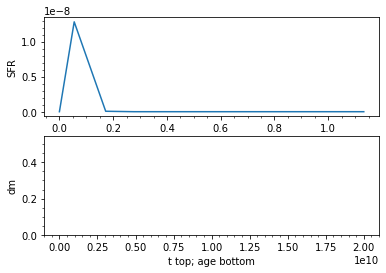

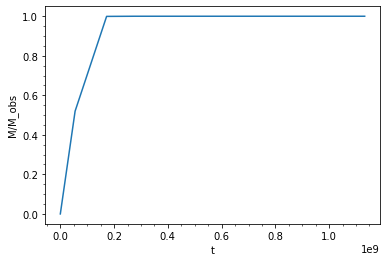

In [25]:
f_name=os.getenv('HOME')+'/Desktop/TESI/sandage_varZ_v4.1eq.fits'
hdul=fits.open(f_name)
data=hdul[1].data

number=5219 #Number model ------array(5219,  17559,  28457,  47761,  64218, 100645, 104552, 147842,201290, 208255, 249577, 253062, 260145, 387896, 392605, 399713,
                                 #432255, 433421, 445350, 460919, 485628, 486601)

        
t_obs=10.0**(data[number][0]) #t_obs in yr
tau=10.0**(data[number][1]) #tau in yr
Nburst=data[number][5]
A_burst=data[number][7]
t_burst=[0.0]*6
age_burst=[0.0]*6
age_burst=np.where(data[number][6]!=0, 10**(data[number][6]), age_burst) #t_burst in yr
t_burst=np.where(age_burst==0, t_burst, t_obs-age_burst)

hdul1=fits.open(os.getenv('HOME')+'/Desktop/TESI/models/ssp/bc2003_hr_xmiless_m22_chab_ssp_ised.fits')
data_age=hdul1[2].data
N=np.size(data_age)
m_age=[0.0]*N
for i in range(0,N):
    m_age[i]=data_age[i][0]
    
age=[0.0]*N
t=[0.0]*N

for i in range(1,N):
    age[i]=(m_age[i-1]+m_age[i])/2.0
    
t=t_obs-age
t=np.where(t<0.0, 0.0, t)

m=1.0-np.exp(-t**2/(2.0*tau**2))
sfr=t/(tau**2)*np.exp(-t**2/(2.0*tau**2))
Nbins_t=np.size(t)
sfr=(1.0/m[0])*sfr
m=m/m[0]

dm=[0.0]*(Nbins_t)

dm[Nbins_t-1]=m[Nbins_t-1]
for i in range(0, Nbins_t-1, 1):
    dm[i]=m[i]-m[i+1]
    

fig, (ax1,ax2)=plt.subplots(2)
ax1.plot(t, sfr)
ax1.set_ylabel('SFR')
ax1.minorticks_on()
ax2.minorticks_on()
ax2.bar(m_age, dm, align='center', width=0.2)
ax2.set_xlabel('t top; age bottom')
ax2.set_ylabel('dm')

fig, ax3=plt.subplots(1)
ax3.minorticks_on()
ax3.plot(t, m)
#ax3.set_title('t_obs {:4.2e}'.format(t_obs))
ax3.set_xlabel('t')
ax3.set_ylabel('M/M_obs')

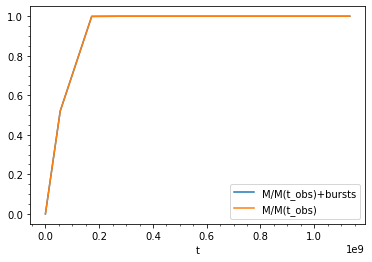

In [26]:
m_b=m
for i in range(0, Nburst):
    m_b=np.where(t>=t_burst[i], m_b+A_burst[i], m_b)

plt.plot(t, m_b, label='M/M(t_obs)+bursts')
plt.plot(t, m, label='M/M(t_obs)')
plt.minorticks_on()
plt.xlabel('t')
plt.legend(loc='lower right')


Text(0, 0.5, 'M(t)/M(t_obs) with bursts')

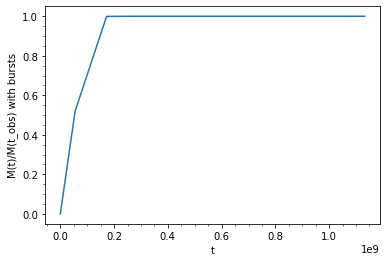

In [27]:
m_bn=m_b/m_b[0] #mass function with burts normalized
plt.plot(t, m_bn)
plt.minorticks_on()
plt.xlabel('t')
plt.ylabel('M(t)/M(t_obs) with bursts')

In [28]:
Mass_tot=1.0+np.sum(A_burst)    
                 
frac50=lambda x: Massb(x, tau, t_obs, A_burst, t_burst, Nburst)/Mass_tot-0.5
frac25=lambda x: Massb(x, tau, t_obs, A_burst, t_burst, Nburst)/Mass_tot-0.25
frac75=lambda x: Massb(x, tau, t_obs, A_burst, t_burst, Nburst)/Mass_tot-0.75
frac90=lambda x: Massb(x, tau, t_obs, A_burst, t_burst, Nburst)/Mass_tot-0.9
frac10=lambda x: Massb(x, tau, t_obs, A_burst, t_burst, Nburst)/Mass_tot-0.1

t50b=bisection(frac50, 0.0, t_obs, 0.01)
t25b=bisection(frac25, 0.0, t_obs, 0.01)
t75b=bisection(frac75, 0.0, t_obs, 0.01)
t90b=bisection(frac90, 0.0, t_obs, 0.01)
t10b=bisection(frac10, 0.0, t_obs, 0.01)

t_sndg=(-t_obs*np.exp(-0.5*(t_obs/tau)**2)+np.sqrt(np.pi/2.0)*tau*math.erf(t_obs/(np.sqrt(2.0)*tau)))/(1.0-np.exp(-0.5*(t_obs/tau)**2))
t_mw=(t_sndg+np.sum(A_burst*t_burst))/Mass_tot

In [29]:
print('age10: ', t_obs-t10b)
print('age25: ', t_obs-t25b)
print('age50: ', t_obs-t50b)
print('age75: ', t_obs-t75b)
print('age90: ', t_obs-t90b)
print('age_mw:', t_obs-t_mw)

age10:  1111299203.6792002
age25:  1097706361.1099782
age50:  1078694319.1112463
age75:  1056558852.1292477
age90:  1034733944.6617067
age_mw: 1075249218.0575798


In [30]:
print('a_b:', A_burst)
print('age_b:', t_obs-t_burst)

a_b: [0. 0. 0. 0. 0. 0.]
age_b: [1.13213406e+09 1.13213406e+09 1.13213406e+09 1.13213406e+09
 1.13213406e+09 1.13213406e+09]


In [31]:
print('t_obs:', t_obs)
print('tau:', tau)

t_obs: 1132134063.7080152
tau: 45387540.088136494
